In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR, OneCycleLR
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import cv2
import scipy.io as sio

import shutil
import math
import os
import re
import gc
import urllib.request
import zipfile
import copy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Augmentation 함수 설계
#========================================================================================================================================================#
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max


def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min ]
    middle_center = image_b[:,y_min:y_max, x_min:x_max]
    middle_right = image_a[:,y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

    return label_a, label_b, ratio

def cutmix(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels_a = []
    mixed_labels_b = []
    ratios =[]

    for i in range(min(batch_size,len(images))):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, min(batch_size,len(images)), (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        label_a, label_b, ratio = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes)
        
        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels_a.append(label_a)
        mixed_labels_b.append(label_b)
        ratios.append(ratio)

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs)
    mixed_labels_a = torch.stack(mixed_labels_a).long()
    mixed_labels_b = torch.stack(mixed_labels_b).long()
    ratios = torch.tensor(ratios, dtype=torch.float32, device=images.device)

    return mixed_imgs, mixed_labels_a, mixed_labels_b, ratios

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b

    return mixed_image, label_a, label_b, ratio

def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels_a = []
    mixed_labels_b = []
    ratios =[]

    for i in range(min(batch_size,len(images))):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, min(batch_size,len(images)), (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, label_a, label_b, ratio = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels_a.append(label_a)
        mixed_labels_b.append(label_b)
        ratios.append(ratio)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs)  # (B, C, H, W)
    mixed_labels_a = torch.stack(mixed_labels_a).long() # (B,)
    mixed_labels_b = torch.stack(mixed_labels_b).long() # (B,)
    ratios = torch.tensor(ratios, dtype=torch.float32, device=images.device)

    return mixed_imgs, mixed_labels_a, mixed_labels_b, ratios

In [4]:
# Transforms 설계
#========================================================================================================================================================#
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor()
])

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.4),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.4),    # 상하 반전
        transforms.RandAugment(num_ops=2, magnitude=10),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화 추가
    ])

In [5]:
#model 설계
#========================================================================================================================================================#
def ResNet(model_name = "RESNET_18", num_classes=10, is_pretrained=True):
    model_list = ["RESNET_18", "RESNET_34", "RESNET_50", "RESNET_101", "RESNET_152"]
    
    if model_name == "RESNET_18":
        if is_pretrained:
            model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            model = torchvision.models.resnet18()
    elif model_name == "RESNET_34":
        if is_pretrained:
            model = torchvision.models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        else:
            model = torchvision.models.resnet34()
    elif model_name == "RESNET_50":
        if is_pretrained:
            model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        else:
            model = torchvision.models.resnet50()
    elif model_name == "RESNET_101":
        if is_pretrained:
            model = torchvision.models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        else:
            model = torchvision.models.resnet101()
    elif model_name == "RESNET_152":
        if is_pretrained:
            model = torchvision.models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        else:
            model = torchvision.models.resnet152()
    else:
        assert model_name not in model_list, "model name is not appropriate"

    # 이미 GAP과 Dense layer를 포함. AdaptiveAvgPool2d(output_size=(1, 1))은 (1,1) 의 output을 반환
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [6]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [7]:
# 시각화 및 보조 함수/ 기타
#=================================================================================================================================================================================
def Accuracy_function(predicted, labels):
    acc = (predicted == labels).float().mean()
    return acc

def Accuracy_function_mixup(logits, label_a, label_b, ratio):
    _, top_indices = logits.topk(2, dim=1)
    hit_a = (top_indices == label_a.unsqueeze(1)).any(dim=1).float()
    hit_b = (top_indices == label_b.unsqueeze(1)).any(dim=1).float()

    if not torch.is_tensor(ratio):
        ratio=float(ratio)
    
    acc = ((1.0 - ratio) * hit_a +  ratio* hit_b).float().mean()
    
    return acc

def Loss_Visualization(train_losses, val_losses, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_losses)), train_losses, 'b-',label=f'{model_name} {mode1} Loss')
    plt.plot(range(len(val_losses)), val_losses,'r--', label=f'{model_name} {mode2} Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} {mode1} and {mode2} Loss")
    plt.show()

def Acc_Visualization(train_acc, val_acc, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_acc)), train_acc, 'b-',label=f'{model_name} {mode1} Acc')
    plt.plot(range(len(val_acc)), val_acc,'r--', label=f'{model_name} {mode2} Acc')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.title(f"{model_name} {mode1} and {mode2} Acc")
    plt.show()

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0]
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

def visualize_cam(model, img, target_layer_name=None, target_layer_number=None):
    if (target_layer_name or target_layer_number) is None:cam = generate_cam(model, img)
    else:
        cam = generate_grad_cam(model, img)
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

def visualize_cam_on_image(model, img, alpha=0.5, target_layer_name=None, target_layer_number=None):
    img_ori = unnormalize(img)
    title = "Last layer"
    if (model is not None):
        if (target_layer_name is None) and (target_layer_number is None):
            cam = generate_cam(model, img)
        else:
             if target_layer_name is not None:
                 cam = generate_grad_cam(model, img, target_layer_name=target_layer_name)
                 title = target_layer_name
             else:
                 cam = generate_grad_cam(model, img, target_layer_name=target_layer_number)
                 title = "layer" + target_layer_number
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img_ori.shape[1], img_ori.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img_ori * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title(f"{title} CAM Overlay on Image")
    plt.axis('off')
    plt.show()

def generate_grad_cam(model, image, target_layer_name=None, target_layer_number=None):
    model.eval()
    features = {}
    gradients = {}
    target_layer = None

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()


    if target_layer_name is not None:
        # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
        target_layer = dict(model.named_modules()).get(target_layer_name, None)
        if target_layer is None:
            raise ValueError(f"Layer '{target_layer_name}' not found in the model.")
    elif target_layer_number is not None:
        # 모델 내에서 layer의 번호에 해당하는 target_layer를 검색        
        target_layer = model.children()[target_layer_number]
        if target_layer is None:
            raise ValueError(f"Layer '{target_layer_name}' not found in the model.")
    else:
        raise ValueError(f"Layer not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

def visualize_bbox_on_image(img, bbox=None, box_color=(255, 0, 0), thickness=2, return_bbox=False, model=None, threshold=0.5, target_layer_name=None, target_layer_number=None):
    # 원본 이미지 복사
    img_with_bbox = unnormalize(img).copy()
    title = "Last layer"
    if (model is not None) and (bbox is None):
        if (target_layer_name is None) and (target_layer_number is None):
            cam = generate_cam(model, img)
        else:
             if target_layer_name is not None:
                 cam = generate_grad_cam(model, img, target_layer_name=target_layer_name)
                 title = target_layer_name
             else:
                 cam = generate_grad_cam(model, img, target_layer_number=target_layer_number)
                 title = "layer" + target_layer_number
        cam_resized = cv2.resize(cam, (img_with_bbox.shape[1], img_with_bbox.shape[0]))
        bbox = get_bbox(cam_resized, threshold=threshold)
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
        return
        
    plt.figure(figsize=(6,6))
    plt.imshow(img_with_bbox)
    plt.title(f"Image with Bounding Box from CAM - {title}")
    plt.axis("off")
    plt.show()
    if return_bbox:
        return img_with_bbox

def visualize_both_bbox_on_image(img, ground_truth, bbox=None, thickness=2, return_bbox=False, model=None, threshold=0.5, target_layer_name=None, target_layer_number=None):
    # 원본 이미지 복사
    img_with_bbox = unnormalize(img).copy()
    title = "Last layer"
    if (model is not None) and (bbox is None):
        if (target_layer_name is None) and (target_layer_number is None):
            cam = generate_cam(model, img)
        else:
             if target_layer_name is not None:
                 cam = generate_grad_cam(model, img, target_layer_name=target_layer_name)
                 title = target_layer_name
             else:
                 cam = generate_grad_cam(model, img, target_layer_name=target_layer_number)
                 title = "layer" + target_layer_number
        cam_resized = cv2.resize(cam, (img_with_bbox.shape[1], img_with_bbox.shape[0]))
        bbox = get_bbox(cam_resized, threshold=threshold)
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img_with_bbox)
    plt.title(f"Compare with Ground Truth - {title}")
    plt.axis("off")
    plt.show

    print("="*30)
    print(f"IOU: {get_iou(bbox, ground_truth)}")
    print("="*30)
    if return_bbox:
        return img_with_bbox

def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [8]:
# 학습 함수
#=======================================================================================================================================================================
def train_model(model, train_dataset, train_ratio=0.8, valid_dataset=None,
                criterion = 'CE', optimize='SGD', batch_size=256,
                epochs=50, lr = 0.001, verbose = 1, isTrained = False, 
                random_state=None, view_accurate_value = False,num_classes=120,
                is_test=False, with_cutmix=False, cutmix_p=1.0, with_mixup=False, 
                mixup_p=1.0, num_workers=None, transform=None, transform_p=1.0, 
                scheduler=None, warmup_steps=3000, patience=4, model_name="Model1"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if isTrained:
        model.to(device)
    else:
        model = model(
            dropout=DROPOUT
        )
    
        model.to(device)
        
    # 손실 함수
    if criterion=="CE":
        criterion = nn.CrossEntropyLoss()
    elif criterion=="BCE":
        criterion = nn.BCEWithLogitsLoss()

    # 옵티마이저
    if optimize=='AdamW':
        optimizer=optim.AdamW(model.parameters(), lr=lr)
    elif optimize=='Adam':
        optimizer=optim.Adam(model.parameters(), lr=lr)
    elif optimize=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer=optim.Adam(model.parameters(), lr=lr)
    
    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size
    if valid_dataset is None:
        if random_state is None:
            # 랜덤하게 dataset나누기
            tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        else:
            manual_seed = random_state
            generator = torch.Generator().manual_seed(manual_seed)
        
        # 랜덤하게 dataset나누기
        tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)
        if num_workers is not None:
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        else:
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        tr_dataset = train_dataset
        if num_workers is not None:
            val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        else:
            val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    if (scheduler is not None) and scheduler=="Warmup_cosine":
        sched_warmup = LinearLR(optimizer, start_factor=1e-3, end_factor=1.0, total_iters=max(1, warmup_steps))
        sched_cosine = CosineAnnealingLR(optimizer, T_max=max(1, train_size - warmup_steps), eta_min=1e-6)
        scheduler_ = SequentialLR(optimizer, schedulers=[sched_warmup, sched_cosine], milestones=[warmup_steps])
    elif scheduler=="OneCycleLR":
        scheduler_ = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=train_size, epochs=epochs, pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e3)
    else:
        scheduler_ = None

    train_losses = []
    val_losses = []
    train_acc_list = []
    val_acc_list = []

    # trainset에 대해서 transform적용을 위한 wrapper dataset
    class TransformedDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
    
        def __len__(self):
            return len(self.subset)
    
        def __getitem__(self, idx):
            img, label, bbox = self.subset[idx]  # 여기서 img는 tensor
            if self.transform is not None:
                img = self.transform(img)
            return img, label, bbox
    
    #train_loader = apply_cutmix_mixup_on_dataset(tr_dataset, batch_size=batch_size, is_test=is_test, with_cutmix=with_cutmix, with_mixup=with_mixup,num_classes=num_classes)
    model_hist = dict()
    best_val_loss = float('inf')
    best_param = dict()
    
    model.train() 
    for epoch in range(epochs):
        total_loss, total_acc= 0, 0
        transform_p_temp = random.random()
        # PyTorch DataLoader 설정. epoch 마다 섞이게 만듦, 확률에 따라 trainset에 augment 적용
        if transform_p_temp < transform_p:
            transform_temp = None
            t_ = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            tr_dataset_temp = TransformedDataset(tr_dataset, transform = t_)
        else:
            transform_temp = transform
            tr_dataset_temp = TransformedDataset(tr_dataset, transform = transform_temp)
        if num_workers is not None:
            train_loader = DataLoader(tr_dataset_temp, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        else:
            train_loader = DataLoader(tr_dataset_temp, batch_size=batch_size, shuffle=True)
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            with_mixup_temp =False
            with_cutmix_temp=False
            # 확률에 따라 cutmix와 mixup 적용
            if with_cutmix:
                with_cutmix_temp = random.choices([True, False], weights =[cutmix_p,1.0-cutmix_p])[0]
            if with_mixup:
                with_mixup_temp = random.choices([True, False], weights =[mixup_p,1.0-mixup_p])[0]
            if with_mixup_temp and with_cutmix_temp:
                with_mixup_temp = random.choices([True, False])[0]
                with_cutmix_temp = not with_mixup_temp
            loss, acc = train_step(model, batch, optimizer, criterion, device, batch_size=batch_size, num_classes=num_classes,with_cutmix=with_cutmix_temp,with_mixup=with_mixup_temp)
            total_loss += loss
            total_acc += acc             

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        train_losses.append(avg_loss)
        train_acc_list.append(avg_acc.to('cpu'))

        # Validation loss 계산
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                loss, acc= eval_step(model, batch, criterion, device, num_classes=num_classes,with_cutmix=with_cutmix,with_mixup=with_mixup)

                val_loss += loss
                val_acc += acc

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc /= len(val_loader)
        val_acc_list.append(val_acc.to('cpu'))

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_param = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            best_param = copy.deepcopy(model.state_dict())
            early_stop_counter = -float('inf')

       
        if (epoch+1)%verbose==0:
            if view_accurate_value:
                print(f"{model_name} | Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss}, Train Acc: {avg_acc} | Val Loss: {val_loss}, Val Acc: {val_acc}")
            else:
                print(f"{model_name} | Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        model.train()
        
    model.eval()
    model.load_state_dict(best_param)
   
    if not isTrained:
        return model, train_losses, val_losses, train_acc_list, val_acc_list
    else:
        return train_losses, val_losses, train_acc_list, val_acc_list

def train_step(model, batch, optimizer, loss_function, device, batch_size, img_size=224, num_classes=120, with_cutmix=False, with_mixup=False):
    model.train()
    img, label = [x.to(device) for x in batch[:2]]
    if with_cutmix:
        img, label_a, label_b, ratio = cutmix(img, label, batch_size=batch_size, img_size=img_size, num_classes=num_classes)
    elif with_mixup:
        img, label_a, label_b, ratio = mixup(img, label, batch_size=batch_size, img_size=img_size, num_classes=num_classes)
    
    optimizer.zero_grad()

    # 모델 포워드 패스
    logits  = model(img)
    
    # Loss 계산
    if with_cutmix or with_mixup:
        loss = ((1-ratio)*loss_function(logits, label_a) + ratio*loss_function(logits, label_b)).mean()
    else:
        loss = loss_function(logits, label)

    # Backpropagation
    loss.backward()
    optimizer.step()
    if with_cutmix or with_mixup:
        return loss.item(), Accuracy_function_mixup(logits, label_a, label_b, ratio)
        
    _, predicted = logits.max(1)
    return loss.item(), Accuracy_function(predicted, label)
    
def eval_step(model, batch, loss_function, device, num_classes=120, with_cutmix=False, with_mixup=False):
    model.eval()
    
    img, label = [x.to(device) for x in batch[:2]]
    
    # 모델 포워드 패스
    logits  = model(img)
        
    _, predicted = logits.max(1)

    # Loss 계산
    loss = loss_function(logits, label)

    return loss.item(), Accuracy_function(predicted, label)

In [9]:
# 태스트 함수
#=======================================================================================================================================================================
def test(model, dataset, batch_size, loss_rec=[]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn = nn.CrossEntropyLoss()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    loss_rec.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
#Hyperparameters
#================================================================================
BATCH_SIZE = 128
LR = 0.0002
EPOCH = 200
PANTIENCE = 6
VERBOSE = 1
TRAIN_RATIO = 0.8
OPTIMIZER = "Adam"
SCHEDULER="Warmup_cosine"
WARMUP_STEPS=3000
RANDOM_STATE = random.randint(0, 1000000000)
TRAIN_DIR = "C:/Users/USER/Desktop/AIFFEL/work/stanford_dogs/train"
TEST_DIR = "C:/Users/USER/Desktop/AIFFEL/work/stanford_dogs/test"
ANNOTATION_DIR = "C:/Users/USER/Desktop/AIFFEL/work/class_activation_map/Annotation"

In [11]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = "C:/Users/USER/Desktop/AIFFEL/work/class_activation_map/Images"  # 이미지들이 위치한 폴더
mat_dir = "C:/Users/USER/Desktop/AIFFEL/work/class_activation_map/"   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [12]:
# dataset 생성
train_dataset = StanfordDogsDatasetWithBBox(root=TRAIN_DIR, annotation_root=ANNOTATION_DIR, transform=base_transform)
test_dataset = StanfordDogsDatasetWithBBox(root=TEST_DIR, annotation_root=ANNOTATION_DIR, transform=base_transform)
# dataset 정보
ds_info = {
    "num_classes": len(train_dataset.classes),
    "class_names": train_dataset.classes
}
# dataset 랜덤 index
RANDOM_INDEX= random.randint(0, len(test_dataset))

In [13]:
# 함수 선언
ResNet50 = ResNet(model_name = "RESNET_50", num_classes=ds_info["num_classes"])

In [14]:
train_losses, val_losses, train_acc_list, val_acc_list = train_model(ResNet50, train_dataset, train_ratio=TRAIN_RATIO, num_classes=ds_info["num_classes"],
                                                                     criterion = 'CE', optimize=OPTIMIZER, batch_size=BATCH_SIZE,epochs=EPOCH,
                                                                     lr = LR, verbose = VERBOSE, isTrained = True, random_state=RANDOM_STATE,
                                                                     with_mixup=True, mixup_p=0.4, with_cutmix=False, cutmix_p=0.4,
                                                                     transform=transform, transform_p=0.7, patience=PANTIENCE, model_name="ResNet50")

Using device: cuda
ResNet50 | Epoch 1/200 | Train Loss: 3.6753, Train Acc: 0.3126 | Val Loss: 2.6880, Val Acc: 0.3503
ResNet50 | Epoch 2/200 | Train Loss: 2.8052, Train Acc: 0.5013 | Val Loss: 2.0617, Val Acc: 0.5181
ResNet50 | Epoch 3/200 | Train Loss: 2.2808, Train Acc: 0.6760 | Val Loss: 1.7276, Val Acc: 0.5347
ResNet50 | Epoch 4/200 | Train Loss: 1.6593, Train Acc: 0.7851 | Val Loss: 1.7797, Val Acc: 0.5356
ResNet50 | Epoch 5/200 | Train Loss: 2.2421, Train Acc: 0.6105 | Val Loss: 1.7204, Val Acc: 0.5333
ResNet50 | Epoch 6/200 | Train Loss: 1.9644, Train Acc: 0.6657 | Val Loss: 1.9645, Val Acc: 0.4911
ResNet50 | Epoch 7/200 | Train Loss: 2.1996, Train Acc: 0.6654 | Val Loss: 1.7338, Val Acc: 0.5455
ResNet50 | Epoch 8/200 | Train Loss: 2.0284, Train Acc: 0.7000 | Val Loss: 1.6599, Val Acc: 0.5541
ResNet50 | Epoch 9/200 | Train Loss: 2.1670, Train Acc: 0.7795 | Val Loss: 1.7359, Val Acc: 0.5620
ResNet50 | Epoch 10/200 | Train Loss: 1.9529, Train Acc: 0.8096 | Val Loss: 1.5792, Val Ac

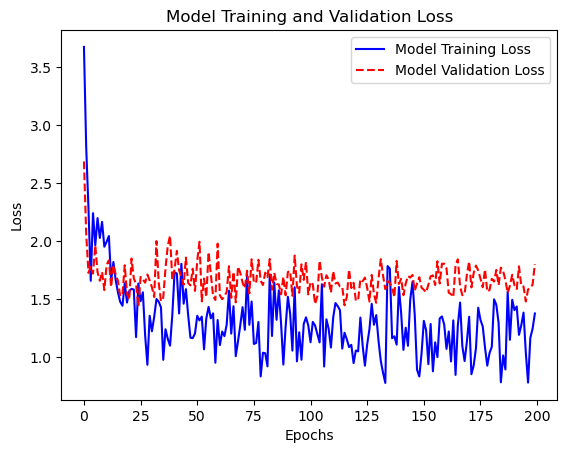

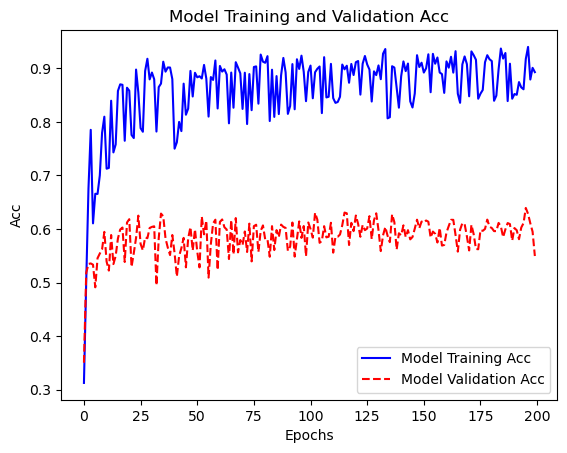

In [15]:
# 학습 결과 시각화
Loss_Visualization(train_losses, val_losses)
Acc_Visualization(train_acc_list, val_acc_list)

In [16]:
rand_img, _, ground_truth=test_dataset[RANDOM_INDEX]
rand_img = rand_img.unsqueeze(0).to(device)
ground_truth = [int(x) for x in ground_truth]

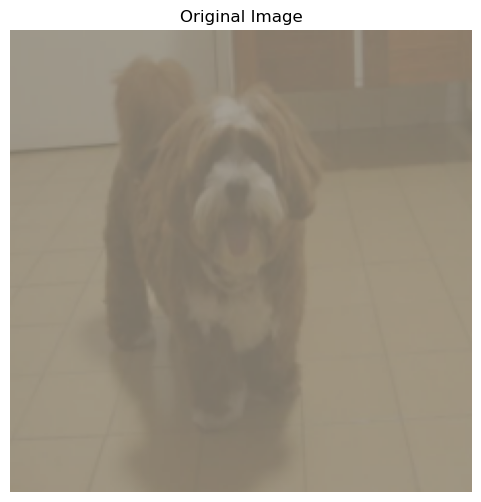

In [17]:
plt.figure(figsize=(6,6))
plt.imshow(unnormalize(rand_img))
plt.title("Original Image")
plt.axis("off")
plt.show()

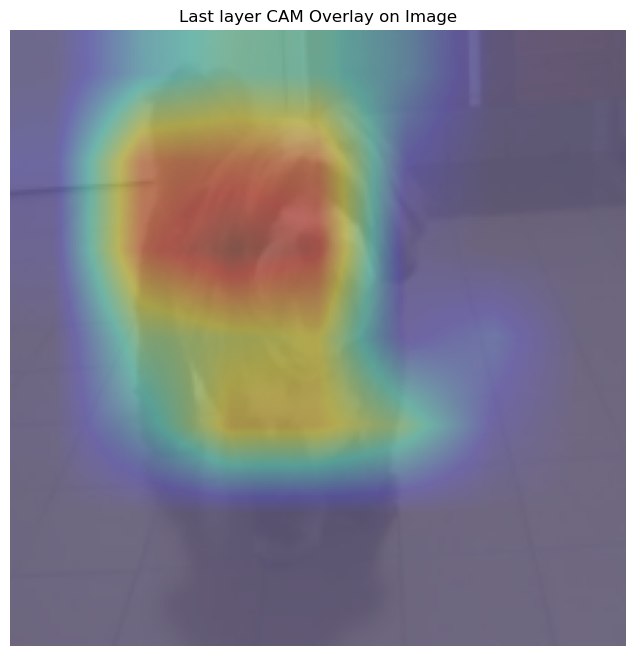

In [18]:
# CAM
visualize_cam_on_image(ResNet50, rand_img, alpha=0.3)

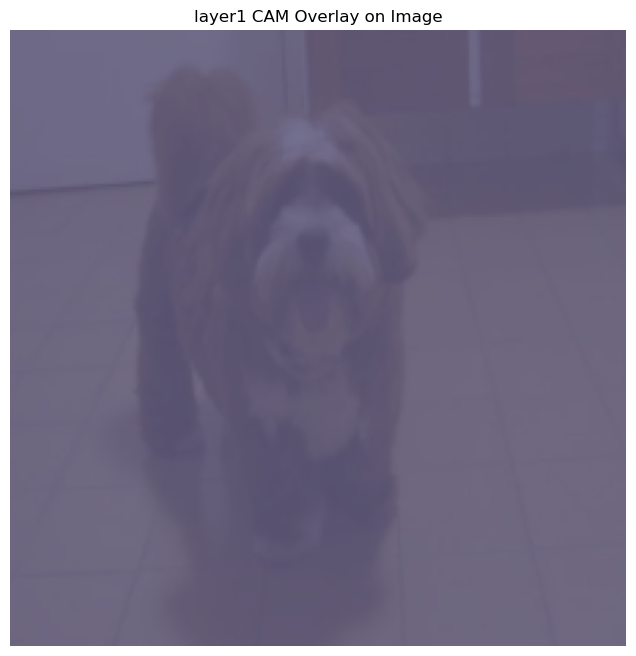

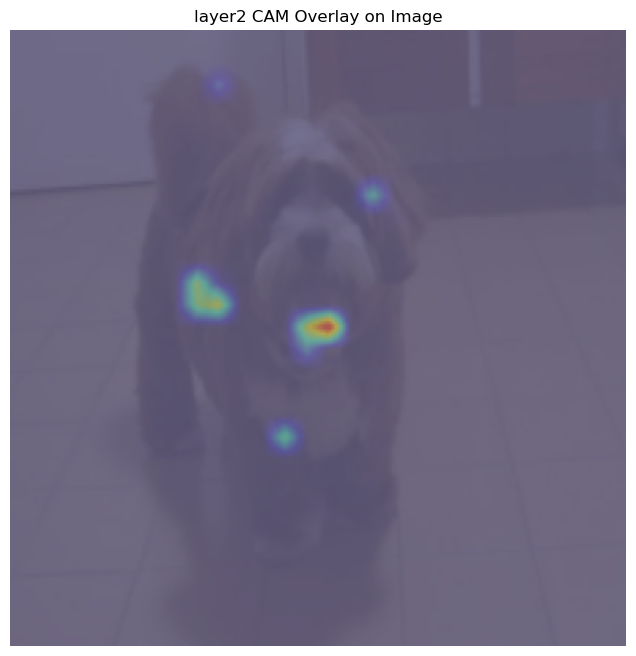

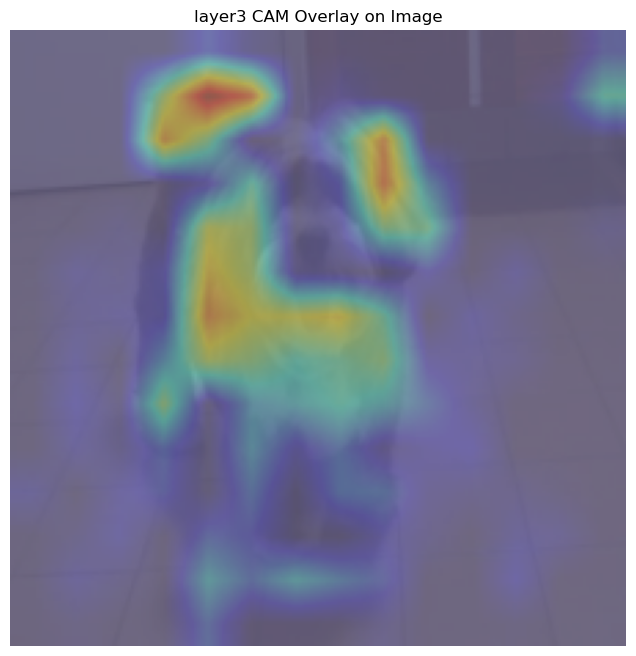

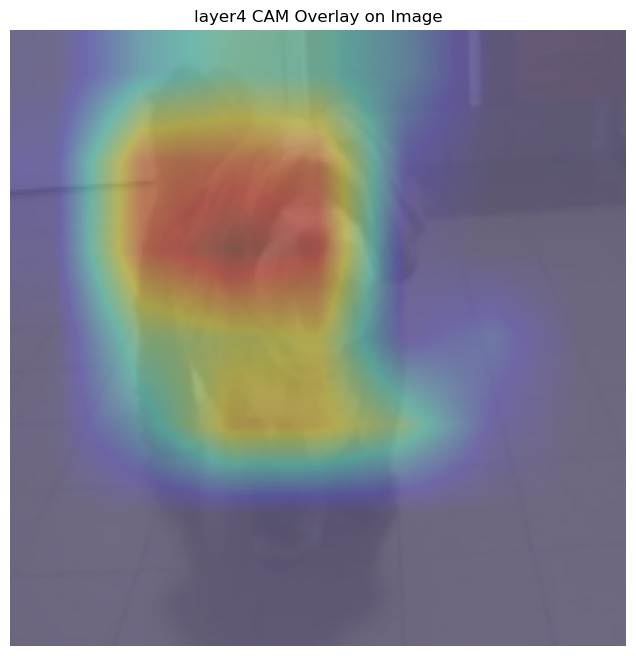

In [22]:
# Grad-CAM
layers = ["layer1","layer2","layer3","layer4"]

for layer in layers:
    visualize_cam_on_image(ResNet50, rand_img, alpha=0.3, target_layer_name=layer)

활성화된 영역이 없습니다.


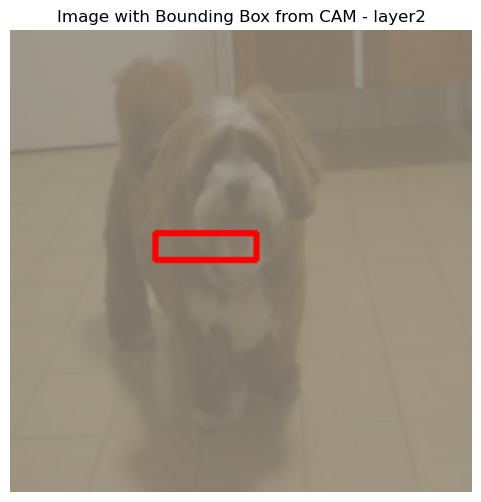

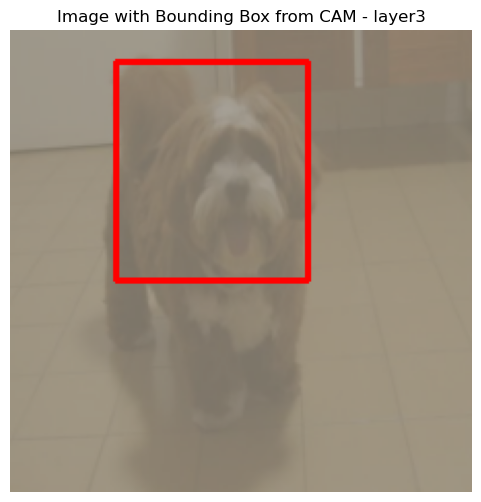

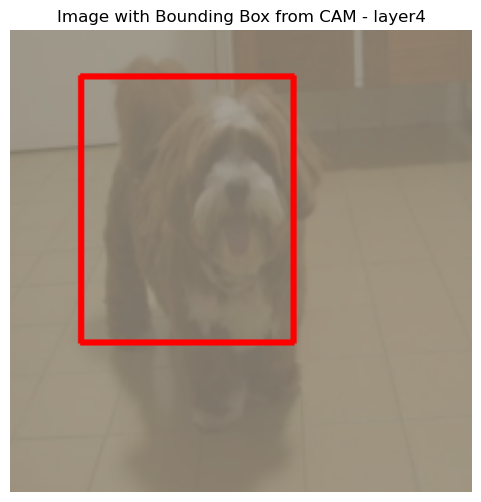

In [20]:
# bbox with Grad-CAM (target_layer_name이 None이면 CAM으로 적용)
for layer in layers:
    visualize_bbox_on_image(rand_img, model=ResNet50, target_layer_name=layer)

IOU: 0.538279088153907


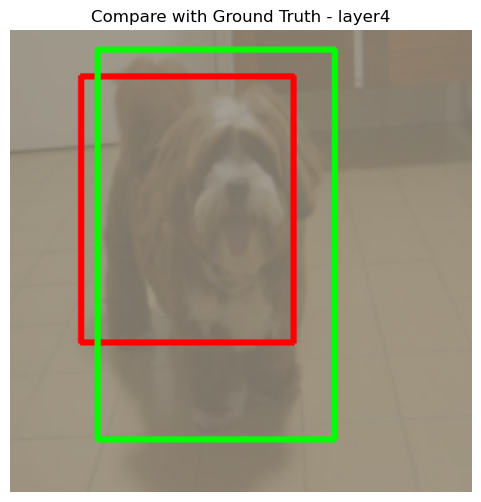

In [21]:
# bbox/ground_truth with Grad-CAM (target_layer_name이 None이면 CAM으로 적용)
visualize_both_bbox_on_image(rand_img,ground_truth=ground_truth, model=ResNet50, target_layer_name="layer4")

# 결론

실험 결과와 같이 CAM과 마지막 layer에서의 Grad-CAM은 같은 class activation map을 반환한다는 것을 확인할 수 있었습니다. 이는, Grad-CAM이 CAM의 일반화 된 기법이기 때문에 필연적인 결과였습니다. 단, Grad-CAM은 CAM과 다르게 구조를 강제하지 않고 원하는 layer의 결과를 볼 수 있습니다.

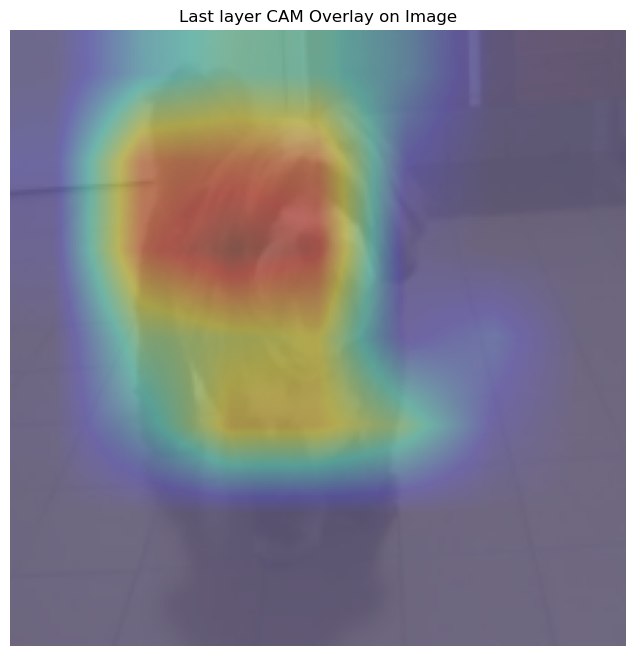

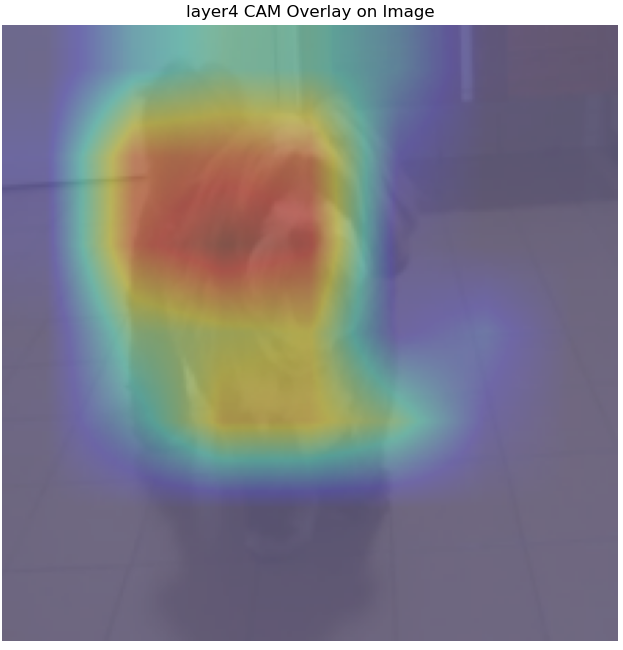

CAM에서 볼 수 없었던 모델의 추론 과정을 Grad-CAM에서 자세히 볼 수 있습니다. 이전 결과와 같이 layer1부터 layer4까지의 모델이 결정을 내리기 까지의 과정을 볼 수 있었습니다.

원본 이미지는 다음과 같습니다.

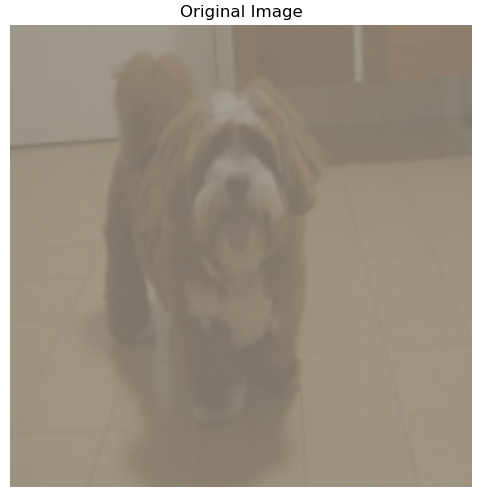

모델이 layer1에서 집중한 부분은 거의 대부분이 점, 선, 면으로 이루어진 부분을 집중합니다. 하지만, Grad-CAM에서는 거의 활성화 된 영역이 없습니다. 이는, 신호가 미약하지만 거의 대부분의 영역에서 활성화 되었다고 해석할 수도 있고 모델이 layer1에서는 거의 활성화된 픽셀들이 없다고 해석할 수 도 있습니다. 하지만, 활성도에 대하여 모델이 layer를 거쳐 갈 수록 특정한 지점의 패턴에 집중하는 과정이라고 가정하면 첫번째 해석이 더 상황에 알맞습니다. 이는 다른 모든 layer의 결과를 통해 알 수 있습니다. 따라서, 모델은 거의 대부분의 공간에 집중하고 있는것을 알 수 있습니다. 이는 첫번째 layer가 저차원적인 요소들을 인식한다는 것을 증명합니다.

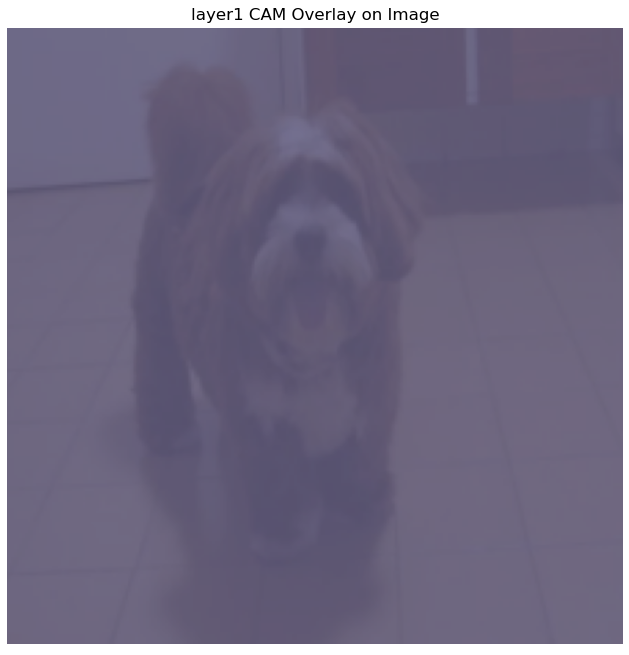

layer2에서는 집중하는 부분들이 급격하게 줄어듭니다. 이는 모델을 검출하는 데 필요하지 않은 부분과 필요한 부분을 고려하는 것으로 보이며 강아지라는 형상을 아직까지는 인식하지 못한것으로 보입니다. 또한, 보이는 이미지에서 어두운 색과 강아지의 가장자리 부분이 많이 활성화 된것으로 보아 모델은 배경과 객체를 색 차이가 많이 나는 부분부터 구분하는 것으로 해석할 수 있습니다.

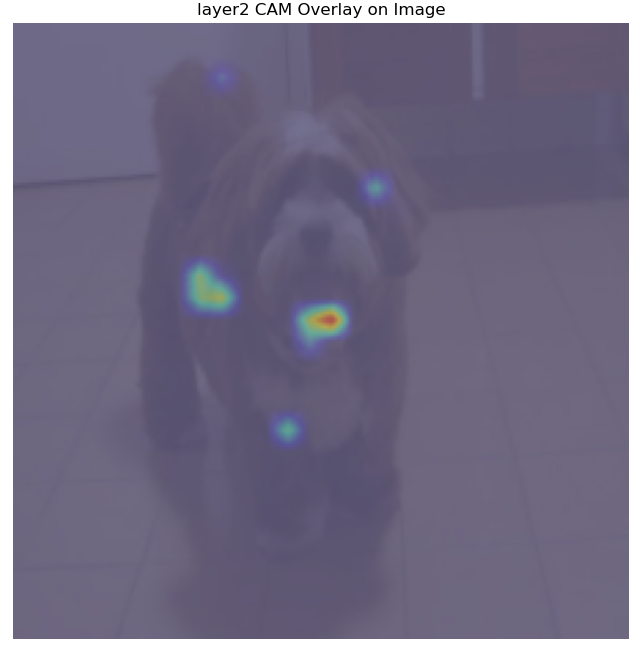

layer3에서는 가장자리를 조금 더 명확하게 검출합니다. 이전 결과를 바탕으로 기존에 배경과 구분하지 못한 부분을 구분할 수 있게 됩니다. 이는, 모델이 점점 구조와 패턴을 파악해 가는 과정을 보여줍니다. 또한, 이전보다 활성화의 분포가 연속적으로 변하였습니다. 이러한 활성화의 분포는 Receptive field가 증가하면서 한 filter가 더 많은 픽셀을 참조하게 되어 이전보다 거시적인 패턴을 인식하게 된 결과일 수 있습니다. 또한, layer2의 결과를 바탕으로 어떤 패턴에서 얼만큼의 영향을 받는지도 일부 해석할 수 있습니다.

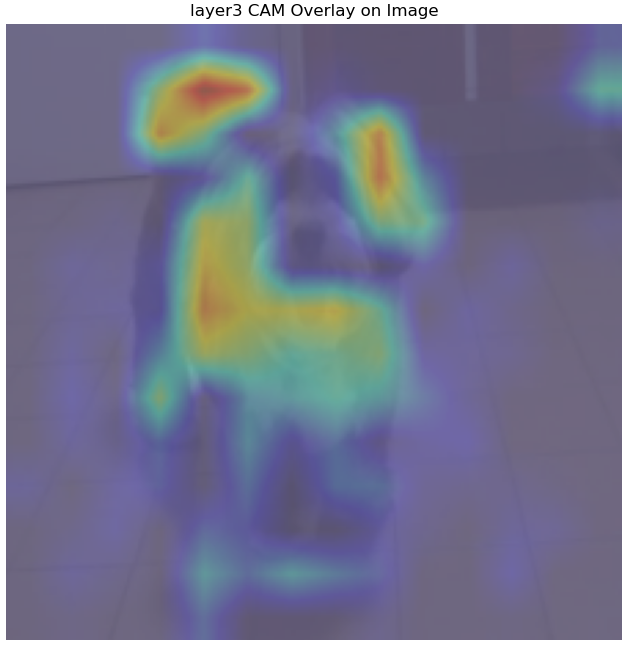

layer4에서는 CAM과 같은 결과가 나왔으며 강아지의 대부분의 영역이 검출되었습니다. 해당 CAM이 보여주는 결과는 가장자리 검출보다 강아지의 전체적인 패턴 검출이 영향을 많이 끼쳤다는 것을 알 수 있습니다. 이는 ACoL에서 언급하였다 싶이 가장자리보다는 특징이 주로 나타나는 위치에 중점적으로 활성화되기 때문에 정확한 가장자리를 알기 힘든 단점이 그대로 들어납니다.

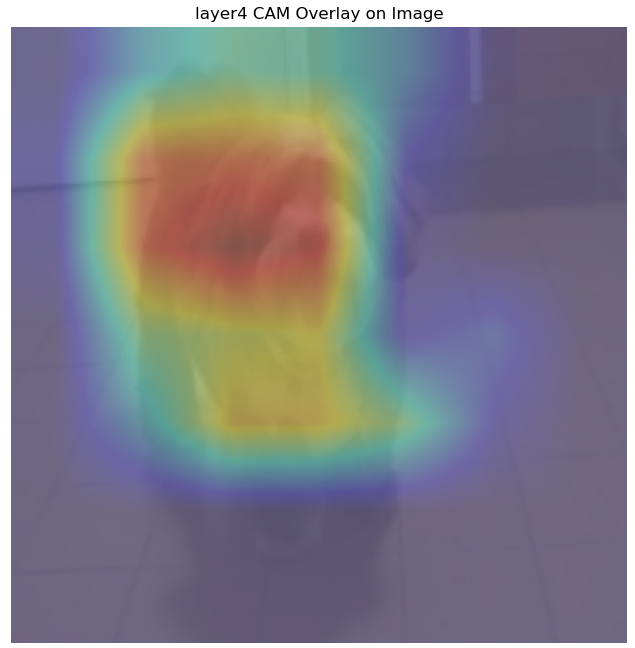

위의 결과를 토대로 객체 검출을 해볼 경우 layer별 다음과 같은 요소로 bounding box가 결정되었다고 해석할 수 있습니다.
- **layer1**: 점, 선, 면과 같은 저차원적인 특성들을 거의 대부분 추출합니다. 신호가 약하여 이미지 상으로는 표기 되비 않습니다.
- **layer2**: 차이가 많이 나는 어두운 배경은 어느정도 구분했으나 여전히 점, 선, 면과 같은 저차원 특징들 에서 점점 거시적인 패턴을 파악하고 특정 패턴에 집중하고 있습니다.
- **layer3**: 어느정도 강아지의 가장자리를 검출 하였으며 강아지의 전체적인 패턴을 파악하고 있는 단계로 해석됩니다.
- **layer4**: 강아지의 패턴을 찾았지만 그보다 조금 더 넓은 영역이 감지되었습니다.

최종적인 IOU의 결과는 0.5383 이 산출되었습니다. 이는, bounding box와 ground truth가 같이 있는 결과를 보면 bounding box가 과소하게 추정되었다는 것을 알 수 있습니다. 다리의 형태와 같은 부분을 모델이 인식하기에 판단에 중요하지 않은 부분으로 판단했을 가능성이 있습니다. 그러한 관점에서 본다면 ground truth는 강아지의 다리를 포함한 대부분을 bounding box로 재시하기 때문에 필요하지 않은 픽셀들이 포함되었지만, 모델이 예측한 부분은 강아지의 종류를 예측하기에 필요한 부분만을 bounding box로 감지하였기에 불필요한 픽셀이 상대적으로 덜 포함되었습니다. 모델에서 IOU가 0.5383이 나온 이유를 유추해 본다면 task 자체가 object detection을 요구하지 않았고, ground truth의 boounding box가 불필요한 픽셀을 포함하여 모델이 효율적으로 해당 부분을 noise로 판단하고 강아지의 특징을 더 강하게 표현하는 부분에 집중했을 가능성이 있습니다. 이는, bounding box도 강아지와 같은 객체의 가장자리를 정밀하게 표현하기에 한계가 있다는 점에서 기인합니다.

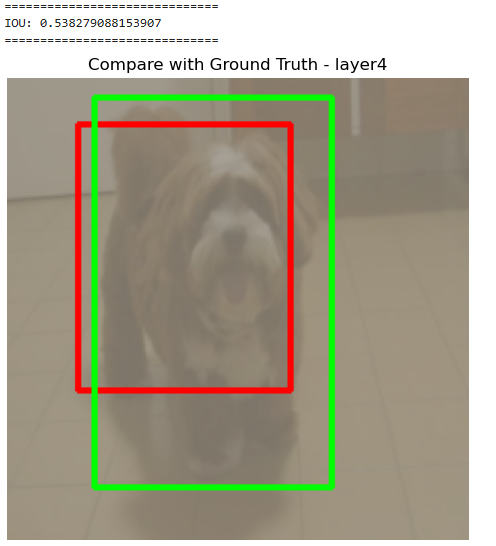